In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.utils.data
import os
import time
import copy
from PIL import Image
from sklearn.metrics import confusion_matrix
import seaborn as sns
import cv2
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
classes = ['NEG', 'POS']

In [2]:
TEST = "C:\\Users\\sanzh/Desktop/CHOC Data/test"
TRAIN = "C:\\Users\\sanzh/Desktop/CHOC Data/train"
TRAIN_f = "C:\\Users\\sanzh/Desktop/CHOC Data/train_pda_filtered"
VAL = "C:\\Users\\sanzh/Desktop/CHOC Data/Val"
transform_normalize = transforms.Compose([transforms.Resize((224, 224)),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean = [0.1295, 0.1322, 0.1428],
                                                        std = [0.1695, 0.1727, 0.1858])]) 
POS = "C:\\Users\\sanzh/Desktop/CHOC Data/test/POS"
NEG = "C:\\Users\\sanzh/Desktop/CHOC Data/test/NEG"
tPOS = TRAIN + "/POS"
tNEG = TRAIN + "/NEG"
fPOS = TRAIN_f + "/POS"
fNEG = TRAIN_f + "/NEG"

In [3]:
def createPathList(path):
    paths = []
    for root, dirs, files in os.walk(path):
        for d in dirs:
            paths.append(os.path.join(root, d))
    return paths

In [4]:
tPOSpathlist = createPathList(tPOS)
fPOSpathlist = createPathList(fPOS)
pos_video_dict = {}
for clips in range(len(tPOSpathlist)):
    counts = []
    num_frames = 0
    for root, dirs, files in os.walk(tPOSpathlist[clips]):
        for f in files:
            num_frames += 1
    counts.append(num_frames)
    pos_video_dict[os.path.split(tPOSpathlist[clips])[1]] = counts
for clips in range(len(fPOSpathlist)):
    num_frames = 0
    for root, dirs, files in os.walk(fPOSpathlist[clips]):
        for f in files:
            num_frames += 1
    pos_video_dict[os.path.split(tPOSpathlist[clips])[1]].append(num_frames)

In [5]:
tNEGpathlist = createPathList(tNEG)
fNEGpathlist = createPathList(fNEG)
neg_video_dict = {}
for clips in range(len(tNEGpathlist)):
    counts = []
    num_frames = 0
    for root, dirs, files in os.walk(tNEGpathlist[clips]):
        for f in files:
            num_frames += 1
    counts.append(num_frames)
    neg_video_dict[os.path.split(tNEGpathlist[clips])[1]] = counts
for clips in range(len(fNEGpathlist)):
    num_frames = 0
    for root, dirs, files in os.walk(fNEGpathlist[clips]):
        for f in files:
            num_frames += 1
    neg_video_dict[os.path.split(tNEGpathlist[clips])[1]].append(num_frames)

In [8]:
# 298, 334, 338, 357
#neg_video_dict

In [6]:
neg_ratios = []
for key in neg_video_dict.keys():
    ratio = neg_video_dict[key][1]/neg_video_dict[key][0]
    neg_ratios.append(ratio)
#neg_ratios

In [7]:
total = 0
filtered = 0
for key in pos_video_dict.keys():
    total += pos_video_dict[key][0]
    filtered += pos_video_dict[key][1]
filtered, total

(5082, 15185)

In [8]:
pos_ratios = []
for key in pos_video_dict.keys():
    ratio = pos_video_dict[key][1]/pos_video_dict[key][0]
    pos_ratios.append(ratio)

(array([18., 21., 22., 31., 21., 35., 24., 16.,  8.,  3.]),
 array([0.01098901, 0.08529995, 0.15961088, 0.23392182, 0.30823275,
        0.38254369, 0.45685462, 0.53116556, 0.60547649, 0.67978743,
        0.75409836]),
 <BarContainer object of 10 artists>)

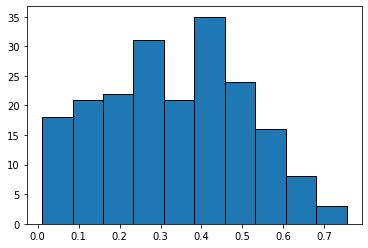

In [12]:
plt.hist(pos_ratios, edgecolor = 'black')

{'whiskers': [<matplotlib.lines.Line2D at 0x1efe8ce6280>,
 'caps': [<matplotlib.lines.Line2D at 0x1efe8ce68b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1efe8cd6f70>],
 'medians': [<matplotlib.lines.Line2D at 0x1efe8ce6dc0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1efe8cf30d0>],
 'means': []}

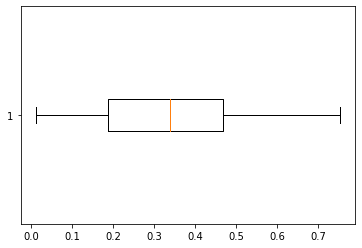

In [13]:
plt.boxplot(pos_ratios, vert = False)

In [9]:
thresh = np.mean(pos_ratios)
thresh

0.33263345994366383

In [10]:
def createTestDataset(path, transform):
    images = {}
    path_list = createPathList(path)
    for clips in range(len(path_list)):
        clips_images = []
        for root, dirs, files in os.walk(path_list[clips]):
            for f in files:
                im = Image.open(os.path.join(root, f))
                input_tensor = transform(im)
                input_batch = input_tensor.unsqueeze(0)
                clips_images.append(input_batch)
        images[os.path.split(path_list[clips])[1]] = clips_images
    return images 

In [11]:
def getPredictions(model, dataset):
    model.eval()
    keys = dataset.keys()
    pred_dict = {}
    for key in keys:
        clip_pred = []
        for frame in dataset[key]:
            with torch.no_grad():
                frame = frame.to(device)
                output = model(frame)
            _, pred = torch.max(output, 1)
            clip_pred.append(pred.cpu().item())
        pred_dict[key] = clip_pred
    return pred_dict

In [12]:
def predictPDA(preds, classes, alpha = 0.5):
    keys = preds.keys()
    pda_dict = {}
    for key in keys:
        ratio = sum(preds[key])/len(preds[key])
        if ratio > alpha:
            pda = classes[1]
        else:
            pda = classes[0]
        pda_dict[key] = pda
    return pda_dict

In [13]:
def getRatio(preds):
    keys = preds.keys()
    ratio_dict = {}
    for key in keys:
        ratio = sum(preds[key])/len(preds[key])
        ratio_dict[key] = ratio
    return ratio_dict

In [66]:
def countCorrect(preds, pda):
    counts = list(preds.values()).count(pda)
    print("Correctly predicted ", pda, ": ", counts, "/", len(preds.values()))

In [82]:
def getMetrics(pos_preds, neg_preds):
    true_pos = list(pos_preds.values()).count("POS")
    true_neg = list(neg_preds.values()).count("NEG")
    false_neg = len(pos_preds) - true_pos
    false_pos = len(neg_preds) - true_neg
    sens = true_pos/(true_pos + false_neg)
    spec = true_neg/(true_neg + false_pos)
    ppv = true_pos/(true_pos + false_pos)
    npv = true_neg/(true_neg + false_neg)
    print("Sensitivity: ", '%.3f' %(sens), "\n",
         "Specificity: ", '%.3f' %spec, "\n",
         "PPV: ", '%.3f' %ppv, "\n",
         "NPV: ", '%.3f' %npv)

In [15]:
# create Validation Dataset
pos_val = createTestDataset(VAL + "/POS", transform_normalize)
neg_val = createTestDataset(VAL + "/NEG", transform_normalize)

In [16]:
# Create Validation Labels
y_val = [None] * (len(createPathList(VAL + "/POS")) + len(createPathList(VAL + "/NEG")))
for i in range(len(createPathList(VAL + "/POS"))):
    y_val[i] = 'POS'
for j in range(len(createPathList(VAL + "/POS")), len(y_val)):
    y_val[j] = 'NEG'

In [17]:
# create Test datasets
pos_images = createTestDataset(POS, transform_normalize)
neg_images = createTestDataset(NEG, transform_normalize)

In [18]:
# Create Test Labels
y_actual = [None] * (34 + 38)
for i in range(34):
    y_actual[i] = 'POS'
for j in range(34, len(y_actual)):
    y_actual[j] = 'NEG'

In [19]:
# MobileNet-V2 
mobilenet = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
mobilenet.classifier[1] = nn.Linear(mobilenet.last_channel, 2)
path = "C:\\Users\\sanzh/Desktop/models/mobileNet_v2.pt"
mobilenet.load_state_dict(torch.load(path))
mobilenet.to(device)

Using cache found in C:\Users\sanzh/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\sanzh\anaconda3\envs\gpu2\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\sanzh\anaconda3\envs\gpu2\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [20]:
# Get predictions for each frame in Test Data
startTime = time.time()
mobile_pos = getPredictions(mobilenet, pos_images)
mobile_neg = getPredictions(mobilenet, neg_images)

# Time elapsed
print("Time: ", time.time() - startTime, "seconds")

Time:  43.417463064193726 seconds


In [21]:
# Get predictions for each frame in Validation Data
mobile_pos_val = getPredictions(mobilenet, pos_val)
mobile_neg_val = getPredictions(mobilenet, neg_val)

In [91]:
# Predict PDA of echocardiogram based on alpha treshold for validation data
mobile_pos_val_pda = predictPDA(mobile_pos_val, classes, alpha = 0.2)
mobile_neg_val_pda = predictPDA(mobile_neg_val, classes, alpha = 0.2)

# Count correctly predicted positive
countCorrect(mobile_pos_val_pda, 'POS')

# Count correctly predicted negative
countCorrect(mobile_neg_val_pda, 'NEG')

Correctly predicted  POS :  35 / 38
Correctly predicted  NEG :  34 / 36


In [92]:
# Validation Confusion Matrix
y_pred_val = list(mobile_pos_val_pda.values())
neg_predicted_labels_val = list(mobile_neg_val_pda.values())
y_pred_val.extend(neg_predicted_labels_val)
cm = confusion_matrix(y_val, y_pred_val)
cm

array([[34,  2],
       [ 3, 35]], dtype=int64)

In [93]:
# Validation
getMetrics(mobile_pos_val_pda, mobile_neg_val_pda)

Sensitivity:  0.921 
 Specificity:  0.944 
 PPV:  0.946 
 NPV:  0.919


In [94]:
# Predict PDA based on alpha threshold for test data
mobile_pos_pda = predictPDA(mobile_pos, classes, alpha = 0.2)
mobile_neg_pda = predictPDA(mobile_neg, classes, alpha = 0.2)

# Count correctly predicted positive
countCorrect(mobile_pos_pda, 'POS')

# Count correctly predicted negative
countCorrect(mobile_neg_pda, 'NEG')

Correctly predicted  POS :  31 / 34
Correctly predicted  NEG :  37 / 38


In [95]:
# Test Confusion Matrix
y_pred = list(mobile_pos_pda.values())
neg_predicted_labels = list(mobile_neg_pda.values())
y_pred.extend(neg_predicted_labels)
cm = confusion_matrix(y_actual, y_pred)
cm

array([[37,  1],
       [ 3, 31]], dtype=int64)

In [96]:
# Test
getMetrics(mobile_pos_pda, mobile_neg_pda)

Sensitivity:  0.912 
 Specificity:  0.974 
 PPV:  0.969 
 NPV:  0.925


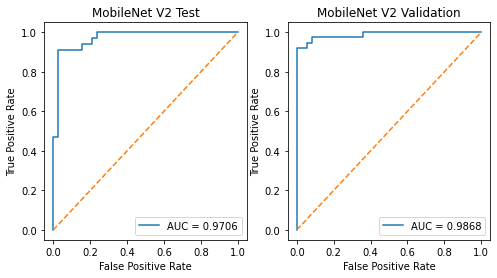

In [136]:
# Test ROC
mobile_pos_ratio = list(getRatio(mobile_pos).values())
mobile_neg_ratio = list(getRatio(mobile_neg).values())
mobile_pos_ratio.extend(mobile_neg_ratio)
mobile_fpr, mobile_tpr, mobile_thresh = roc_curve(y_actual, mobile_pos_ratio, pos_label = 'POS')
mobile_auc = round(roc_auc_score(y_actual, mobile_pos_ratio), 4)
#Validation ROC
mobile_val_pos_ratio = list(getRatio(mobile_pos_val).values())
mobile_val_neg_ratio = list(getRatio(mobile_neg_val).values())
mobile_val_pos_ratio.extend(mobile_val_neg_ratio)
mobile_val_fpr, mobile_val_tpr, mobile_val_thresh = roc_curve(y_val, mobile_val_pos_ratio, pos_label = 'POS')
mobile_val_auc = round(roc_auc_score(y_val, mobile_val_pos_ratio), 4)

plt.figure(figsize = (8, 4))
plt.subplot(1, 2, 1)
plt.plot(mobile_fpr, mobile_tpr, label = "AUC = "+str(mobile_auc))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(mobile_fpr, mobile_fpr, linestyle = '--')
plt.title("MobileNet V2 Test")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mobile_val_fpr, mobile_val_tpr, label = "AUC = "+str(mobile_val_auc))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(mobile_val_fpr, mobile_val_fpr, linestyle = '--')
plt.title("MobileNet V2 Validation")
plt.legend()

In [25]:
mobile_thresh[np.argmax(mobile_tpr - mobile_fpr)]

0.23333333333333334

In [27]:
mobile_val_thresh[np.argmax(mobile_val_tpr - mobile_val_fpr)]

0.25806451612903225

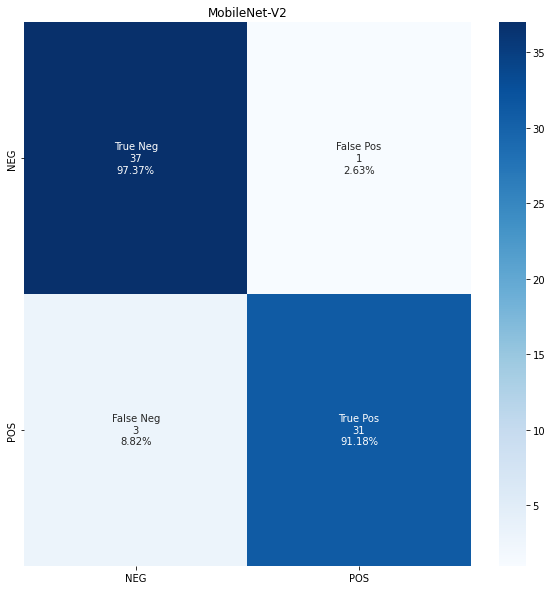

In [45]:
# Confusion Matrix
y_pred = list(mobile_pos_pda.values())
neg_predicted_labels = list(mobile_neg_pda.values())
y_pred.extend(neg_predicted_labels)
cm = confusion_matrix(y_actual, y_pred)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cmn.flatten()]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cm, annot = labels, fmt = '', xticklabels = classes, yticklabels = classes, cmap='Blues')
ax.set_title('MobileNet-V2')
plt.show(block = False)

In [28]:
# EfficientNet_B3
efficientnet_b3 = torchvision.models.efficientnet_b3(weights = True)
efficientnet_b3.classifier[-1].out_features = 2
path = "C:\\Users\\sanzh/Desktop/models/efficient_net_b3.pt"
efficientnet_b3.load_state_dict(torch.load(path))
efficientnet_b3.to(device)

C:\Users\sanzh\anaconda3\envs\gpu2\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [29]:
# Get predictions for each frame
startTime = time.time()
b3_pos = getPredictions(efficientnet_b3, pos_images)
b3_neg = getPredictions(efficientnet_b3, neg_images)

# Time elapsed
print("Time: ", time.time() - startTime, "seconds")

Time:  86.42014384269714 seconds


In [30]:
# Get predictions for each frame in Validation Data
b3_pos_val = getPredictions(efficientnet_b3, pos_val)
b3_neg_val = getPredictions(efficientnet_b3, neg_val)

In [107]:
# Predict PDA of echocardiogram based on alpha treshold for validation data
b3_pos_val_pda = predictPDA(b3_pos_val, classes, alpha = 0.4)
b3_neg_val_pda = predictPDA(b3_neg_val, classes, alpha = 0.4)

# Count correctly predicted positive
countCorrect(b3_pos_val_pda, 'POS')

# Count correctly predicted negative
countCorrect(b3_neg_val_pda, 'NEG')

Correctly predicted  POS :  30 / 38
Correctly predicted  NEG :  36 / 36


In [108]:
# Validation
getMetrics(b3_pos_val_pda, b3_neg_val_pda)

Sensitivity:  0.789 
 Specificity:  1.000 
 PPV:  1.000 
 NPV:  0.818


In [109]:
# Predict PDA based on alpha threshold for test data
b3_pos_pda = predictPDA(b3_pos, classes, alpha = 0.4)
b3_neg_pda = predictPDA(b3_neg, classes, alpha = 0.4)
# Count correctly predicted positive
countCorrect(b3_pos_pda, 'POS')

# Count correctly predicted negative
countCorrect(b3_neg_pda, 'NEG')

Correctly predicted  POS :  28 / 34
Correctly predicted  NEG :  37 / 38


In [110]:
# Test
getMetrics(b3_pos_pda, b3_neg_pda)

Sensitivity:  0.824 
 Specificity:  0.974 
 PPV:  0.966 
 NPV:  0.860


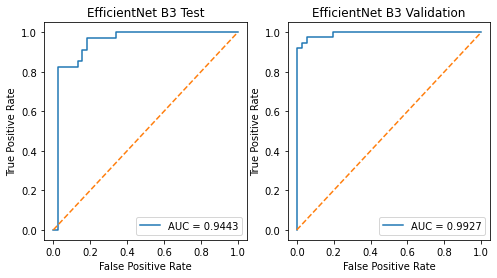

In [137]:
# Test ROC
b3_pos_ratio = list(getRatio(b3_pos).values())
b3_neg_ratio = list(getRatio(b3_neg).values())
b3_pos_ratio.extend(b3_neg_ratio)
b3_fpr, b3_tpr, b3_thresh = roc_curve(y_actual, b3_pos_ratio, pos_label = 'POS')
b3_auc = round(roc_auc_score(y_actual, b3_pos_ratio), 4)
# Validation ROC
b3_pos_val_ratio = list(getRatio(b3_pos_val).values())
b3_neg_val_ratio = list(getRatio(b3_neg_val).values())
b3_pos_val_ratio.extend(b3_neg_val_ratio)
b3_val_fpr, b3_val_tpr, b3_val_thresh = roc_curve(y_val, b3_pos_val_ratio, pos_label = 'POS')
b3_val_auc = round(roc_auc_score(y_val, b3_pos_val_ratio), 4)

plt.figure(figsize = (8, 4))
plt.subplot(1, 2, 1)
plt.plot(b3_fpr, b3_tpr, label = "AUC = "+str(b3_auc))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(b3_fpr, b3_fpr, linestyle = '--')
plt.title("EfficientNet B3 Test")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(b3_val_fpr, b3_val_tpr, label = "AUC = "+str(b3_val_auc))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(b3_val_fpr, b3_val_fpr, linestyle = '--')
plt.title("EfficientNet B3 Validation")
plt.legend()

In [34]:
b3_val_thresh[np.argmax(b3_val_tpr - b3_val_fpr)]

0.26881720430107525

In [36]:
b3_thresh[np.argmax(b3_tpr - b3_fpr)]

0.4583333333333333

In [42]:
# Loading model

efficientnet_b0 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
efficientnet_b0.classifier[-1].out_features = 2
path = "C:\\Users\\sanzh/Desktop/models/efficient_net_b0.pt"
efficientnet_b0.load_state_dict(torch.load(path))
efficientnet_b0.to(device)

Using cache found in C:\Users\sanzh/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub
C:\Users\sanzh/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub\PyTorch\Classification\ConvNets\image_classification\models\common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
C:\Users\sanzh/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub\PyTorch\Classification\ConvNets\image_classification\models\efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


EfficientNet(
  (stem): Sequential(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (activation): SiLU(inplace=True)
  )
  (layers): Sequential(
    (0): Sequential(
      (block0): MBConvBlock(
        (depsep): Sequential(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (se): SequentialSqueezeAndExcitation(
          (squeeze): Linear(in_features=32, out_features=8, bias=True)
          (expand): Linear(in_features=8, out_features=32, bias=True)
          (activation): SiLU(inplace=True)
          (sigmoid): Sigmoid()
          (mul_a_quantizer): Identity()
          (mul_b_quantizer): Identity()
        )
      

In [43]:
# Get predictions for each frame
startTime = time.time()
b0_pos = getPredictions(efficientnet_b0, pos_images)
b0_neg = getPredictions(efficientnet_b0, neg_images)

# Time elapsed
print("Time: ", time.time() - startTime, "seconds")

Time:  47.773128271102905 seconds


In [44]:
# Get predictions for each frame in Validation Data
b0_pos_val = getPredictions(efficientnet_b0, pos_val)
b0_neg_val = getPredictions(efficientnet_b0, neg_val)

In [119]:
# Predict PDA of echocardiogram based on alpha treshold for validation data
b0_pos_val_pda = predictPDA(b0_pos_val, classes, alpha = 0.2)
b0_neg_val_pda = predictPDA(b0_neg_val, classes, alpha = 0.2)

# Count correctly predicted positive
countCorrect(b0_pos_val_pda, 'POS')

# Count correctly predicted negative
countCorrect(b0_neg_val_pda, 'NEG')

Correctly predicted  POS :  35 / 38
Correctly predicted  NEG :  36 / 36


In [120]:
# Validation
getMetrics(b0_pos_val_pda, b0_neg_val_pda)

Sensitivity:  0.921 
 Specificity:  1.000 
 PPV:  1.000 
 NPV:  0.923


In [121]:
# Predict PDA based on alpha threshold for test data
b0_pos_pda = predictPDA(b0_pos, classes, alpha = 0.2)
b0_neg_pda = predictPDA(b0_neg, classes, alpha = 0.2)

# Count correctly predicted positive
countCorrect(b0_pos_pda, 'POS')

# Count correctly predicted negative
countCorrect(b0_neg_pda, 'NEG')

Correctly predicted  POS :  31 / 34
Correctly predicted  NEG :  36 / 38


In [122]:
# Test
getMetrics(b0_pos_pda, b0_neg_pda)

Sensitivity:  0.912 
 Specificity:  0.947 
 PPV:  0.939 
 NPV:  0.923


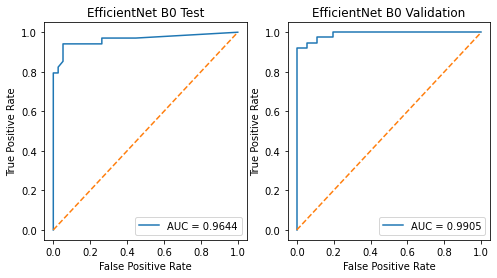

In [138]:
# Test ROC
b0_pos_ratio = list(getRatio(b0_pos).values())
b0_neg_ratio = list(getRatio(b0_neg).values())
b0_pos_ratio.extend(b0_neg_ratio)
b0_fpr, b0_tpr, b0_thresh = roc_curve(y_actual, b0_pos_ratio, pos_label = 'POS')
b0_auc = round(roc_auc_score(y_actual, b0_pos_ratio), 4)
# Validation ROC
b0_pos_val_ratio = list(getRatio(b0_pos_val).values())
b0_neg_val_ratio = list(getRatio(b0_neg_val).values())
b0_pos_val_ratio.extend(b0_neg_val_ratio)
b0_val_fpr, b0_val_tpr, b0_val_thresh = roc_curve(y_val, b0_pos_val_ratio, pos_label = 'POS')
b0_val_auc = round(roc_auc_score(y_val, b0_pos_val_ratio), 4)

plt.figure(figsize = (8, 4))
plt.subplot(1, 2, 1)
plt.plot(b0_fpr, b0_tpr, label = "AUC = "+str(b0_auc))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(b0_fpr, b0_fpr, linestyle = '--')
plt.title("EfficientNet B0 Test")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(b0_val_fpr, b0_val_tpr, label = "AUC = "+str(b0_val_auc))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(b0_val_fpr, b0_val_fpr, linestyle = '--')
plt.title("EfficientNet B0 Validation")
plt.legend()

In [48]:
b0_val_thresh[np.argmax(b0_val_tpr - b0_val_fpr)]

0.2191780821917808

In [50]:
b0_thresh[np.argmax(b0_tpr - b0_fpr)]

0.19831223628691982

In [51]:
# Loading model

mnasnet = torchvision.models.mnasnet1_0(pretrained = True)
mnasnet.classifier[-1].out_features = 2
path = "C:\\Users\\sanzh/Desktop/models/MNASNet.pt"
mnasnet.load_state_dict(torch.load(path))
mnasnet.to(device)

C:\Users\sanzh\anaconda3\envs\gpu2\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\sanzh\anaconda3\envs\gpu2\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MNASNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=MNASNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(16, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(48, 

In [52]:
# Get predictions for each frame
startTime = time.time()
mnas_pos = getPredictions(mnasnet, pos_images)
mnas_neg = getPredictions(mnasnet, neg_images)

# Time elapsed
print("Time: ", time.time() - startTime, "seconds")

Time:  35.84436345100403 seconds


In [53]:
# Get predictions for each frame in Validation Data
mnas_pos_val = getPredictions(mnasnet, pos_val)
mnas_neg_val = getPredictions(mnasnet, neg_val)

In [131]:
# Predict PDA of echocardiogram based on alpha treshold for validation data
mnas_pos_val_pda = predictPDA(mnas_pos_val, classes, alpha = 0.6)
mnas_neg_val_pda = predictPDA(mnas_neg_val, classes, alpha = 0.6)

# Count correctly predicted positive
countCorrect(mnas_pos_val_pda, 'POS')

# Count correctly predicted negative
countCorrect(mnas_neg_val_pda, 'NEG')

Correctly predicted  POS :  34 / 38
Correctly predicted  NEG :  28 / 36


In [132]:
# Validation
getMetrics(mnas_pos_val_pda, mnas_neg_val_pda)

Sensitivity:  0.895 
 Specificity:  0.778 
 PPV:  0.810 
 NPV:  0.875


In [133]:
# Predict PDA based on alpha threshold for test data
mnas_pos_pda = predictPDA(mnas_pos, classes, alpha = 0.6)
mnas_neg_pda = predictPDA(mnas_neg, classes, alpha = 0.6)
# Count correctly predicted positive
countCorrect(mnas_pos_pda, 'POS')

# Count correctly predicted negative
countCorrect(mnas_neg_pda, 'NEG')

Correctly predicted  POS :  31 / 34
Correctly predicted  NEG :  29 / 38


In [134]:
# Test
getMetrics(mnas_pos_pda, mnas_neg_pda)

Sensitivity:  0.912 
 Specificity:  0.763 
 PPV:  0.775 
 NPV:  0.906


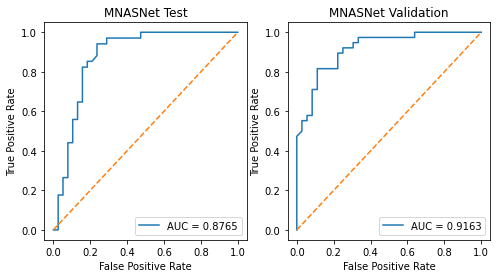

In [139]:
# Test ROC
mnas_pos_ratio = list(getRatio(mnas_pos).values())
mnas_neg_ratio = list(getRatio(mnas_neg).values())
mnas_pos_ratio.extend(mnas_neg_ratio)
mnas_fpr, mnas_tpr, mnas_thresh = roc_curve(y_actual, mnas_pos_ratio, pos_label = 'POS')
mnas_auc = round(roc_auc_score(y_actual, mnas_pos_ratio), 4)
# Validation ROC
mnas_pos_val_ratio = list(getRatio(mnas_pos_val).values())
mnas_neg_val_ratio = list(getRatio(mnas_neg_val).values())
mnas_pos_val_ratio.extend(mnas_neg_val_ratio)
mnas_val_fpr, mnas_val_tpr, mnas_val_thresh = roc_curve(y_val, mnas_pos_val_ratio, pos_label = 'POS')
mnas_val_auc = round(roc_auc_score(y_val, mnas_pos_val_ratio), 4)

plt.figure(figsize = (8, 4))
plt.subplot(1, 2, 1)
plt.plot(mnas_fpr, mnas_tpr, label = "AUC = "+str(mnas_auc))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(mnas_fpr, mnas_fpr, linestyle = '--')
plt.title("MNASNet Test")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mnas_val_fpr, mnas_val_tpr, label = "AUC = "+str(mnas_val_auc))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(mnas_val_fpr, mnas_val_fpr, linestyle = '--')
plt.title("MNASNet Validation")
plt.legend()

In [135]:
mnas_val_thresh[np.argmax(mnas_val_tpr - mnas_val_fpr)]

0.65625

In [59]:
mnas_thresh[np.argmax(mnas_tpr - mnas_fpr)]

0.5925925925925926

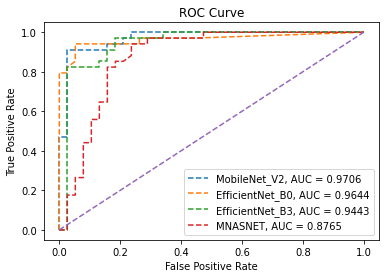

In [79]:
plt.plot(mobile_fpr, mobile_tpr, linestyle = '--', label = "MobileNet_V2, AUC = "+str(mobile_auc))
plt.plot(b0_fpr, b0_tpr, linestyle = '--',label = "EfficientNet_B0, AUC = "+str(b0_auc))
plt.plot(b3_fpr, b3_tpr, linestyle = '--',label = "EfficientNet_B3, AUC = "+str(b3_auc))
plt.plot(mnas_fpr, mnas_tpr, linestyle = '--',label = "MNASNET, AUC = "+str(mnas_auc))
plt.plot(mobile_fpr, mobile_fpr, linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

plt.legend()